In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import itertools, scipy
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
import skbio

import cell2cell as c2c

%matplotlib inline

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


# Load 3D Map

In [2]:
atlas = pd.read_csv('../Data/Digital-3D-Map/Celegans_L1_3D_Atlas_CellTypes.csv')
atlas = atlas.loc[~atlas['Cell Type'].isnull()].reset_index(drop=True)

In [3]:
atlas.head()

,Cell,Lineage Name,Description,Cell2,Name2,X,Y,Z,Cell Type
0,ADEshL,AB arppaaaa,Anterior deirid sheath,ADESHL,ABARPPAAAA,11.134,84.340,12.852,Am/PH_sheath_cells
1,ADEshR,AB arpppaaa,Anterior deirid sheath,ADESHR,ABARPPPAAA,16.990,85.075,13.130,Am/PH_sheath_cells
2,ALML,AB.arppaappa,"Anterior lateral microtubule cell, touch receptor",ALML,ABARPPAAPPA,11.759,120.005,16.090,Touch_receptor_neurons
3,ALMR,AB arpppappa,"Anterior lateral microtubule cell, touch receptor",ALMR,ABARPPPAPPA,16.467,119.037,15.870,Touch_receptor_neurons
4,ALNL,AB plapappppap,Neuron associated with ALM,ALNL,ABPLAPAPPPPAP,12.884,199.753,15.437,Oxygen_sensory_neurons


**Metadata**

In [4]:
meta = pd.read_csv('../Data/RNA-Seq/Celegans_cell_metadata.tsv', sep='\t')
meta.index = [str(i) for i, c in enumerate(meta['#SampleID'])]

# Visualization

In [5]:
# Colors from figure S14 in C elegans paper (cell type expression data)
lut = {'Coelomocytes': (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), # Brown
       'Neurons': (0.596078431372549, 0.3058823529411765, 0.6392156862745098), # Purple
       'Hypodermal/rectal cells': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), # Green
       'Pharyngeal cells': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), # Blue
       'Intestine': (1.0, 1.0, 0.2), # Yellow
       'Body/muscular cells': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), # Red
       'Excretory/Socket/Sheath cells': (1.0, 0.4980392156862745, 0.0), # Orange
       'Sexual cells': (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)} # Pink

In [6]:
fontname = 'Lato'
tick_size = 12
axis_size = 16
legend_size = 14

inline_rc = dict(mpl.rcParams)
#plt.rcParams["font.family"] = fontname

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  


/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/e

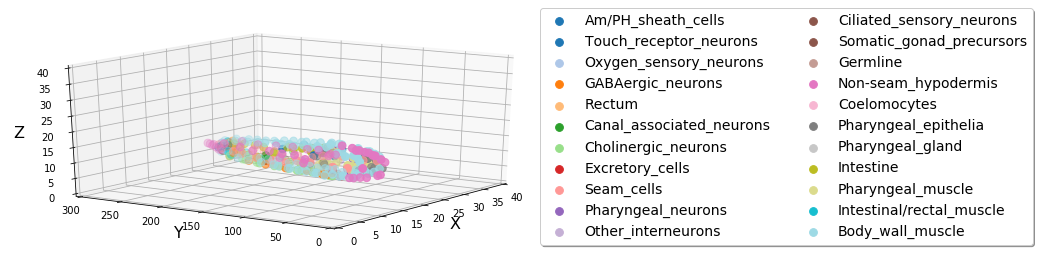

In [7]:
mask = []

NUM_COLORS = len(atlas['Cell Type'].unique())
cm = plt.get_cmap('tab20') # gist_rainbow
fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(111, projection='3d')

for i, cell in enumerate(atlas['Cell Type'].unique()):
    if cell not in mask:
        cell_type = atlas.loc[atlas['Cell Type'] == cell]
        ax.scatter(cell_type['X'], cell_type['Y'], cell_type['Z'], color=cm(1.*i/NUM_COLORS), s=60, label=cell)

ax.set_xlim((0, 40))
ax.set_ylim((0, 300))
ax.set_zlim((0, 40))


ax.set_xlabel('X', fontsize=axis_size)
ax.set_ylabel('Y', fontsize=axis_size)
ax.set_zlabel('Z', fontsize=axis_size)

#ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = tick_size)

ax.view_init(20, 215)
lgd = ax.legend(loc='upper right', bbox_to_anchor=(1.85, 1.025),
                ncol=2, fancybox=True, shadow=True, fontsize=legend_size)

mpl.rcParams.update(inline_rc)
plt.savefig('../Figures/Celegans-3D-Atlas-CellTypes.svg', dpi=300,
                bbox_inches='tight')

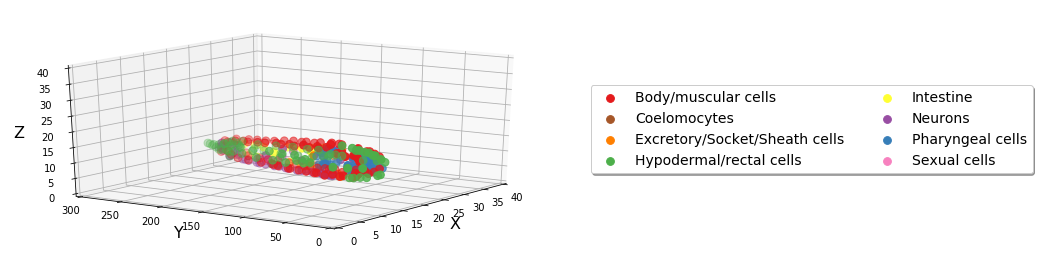

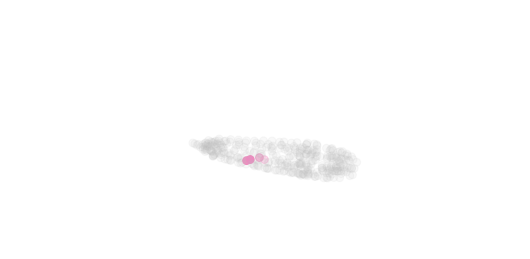

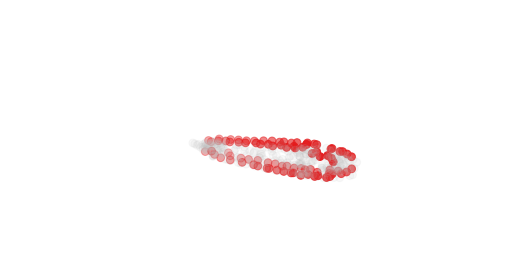

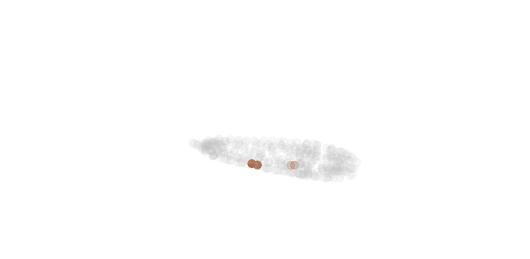

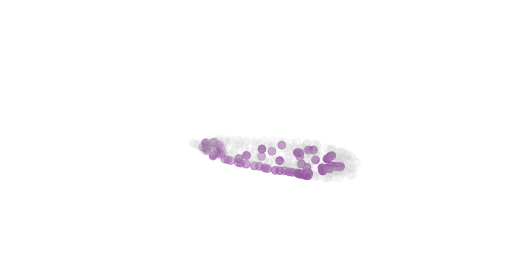

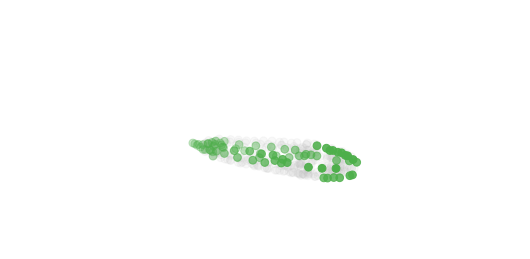

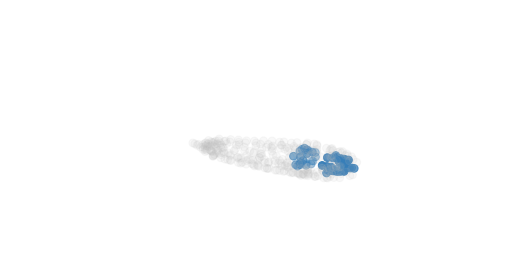

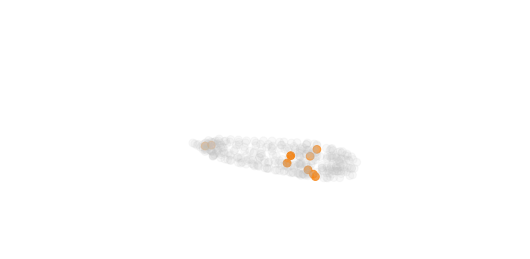

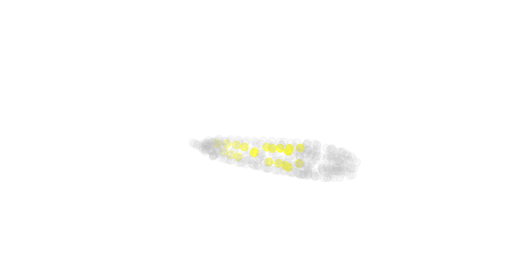

In [8]:
only_worm=True

fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(111, projection='3d')

for i, cell_type in enumerate(sorted(meta['Groups'].unique())):
    cells = meta.loc[meta.Groups == cell_type]['#SampleID'].values
    cell_cords = atlas.loc[atlas['Cell Type'].isin(cells)]
    ax.scatter(cell_cords['X'], cell_cords['Y'], cell_cords['Z'], color=lut[cell_type], s=60, label=cell_type)

ax.set_xlim((0, 40))
ax.set_ylim((0, 300))
ax.set_zlim((0, 40))


ax.set_xlabel('X', fontsize=axis_size)
ax.set_ylabel('Y', fontsize=axis_size)
ax.set_zlabel('Z', fontsize=axis_size)

#ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = tick_size)

view = (20, 215)

ax.view_init(view[0], view[1])
lgd = ax.legend(loc='upper right', bbox_to_anchor=(1.85, 0.71),
                ncol=2, fancybox=True, shadow=True, fontsize=legend_size)

#if only_worm:
#    plt.axis('off')
#    plt.grid(b=None)


plt.savefig('../Figures/Celegans-3D-Atlas-CellGroups-All.svg', dpi=300,
                bbox_inches='tight')
# Individual Plots
for i, cell_type in enumerate(meta['Groups'].unique()):
    fig = plt.figure(figsize=(9.25, 4.5))
    ax = fig.add_subplot(111, projection='3d')
    
    ex_cells = meta.loc[~(meta.Groups == cell_type)]['#SampleID'].values
    ex_cell_cords = atlas.loc[atlas['Cell Type'].isin(ex_cells)]
    ax.scatter(ex_cell_cords['X'],
               ex_cell_cords['Y'],
               ex_cell_cords['Z'],
               color=(0.75, 0.75, 0.75),
               s=60,
               alpha=0.1,
               label=cell_type)
    
    
    cells = meta.loc[meta.Groups == cell_type]['#SampleID'].values
    cell_cords = atlas.loc[atlas['Cell Type'].isin(cells)]
    ax.scatter(cell_cords['X'],
               cell_cords['Y'],
               cell_cords['Z'],
               color=lut[cell_type],
               s=60,
               label=cell_type)
    
    ax.set_xlim((0, 40))
    ax.set_ylim((0, 300))
    ax.set_zlim((0, 40))


    ax.set_xlabel('X', fontsize=axis_size)
    ax.set_ylabel('Y', fontsize=axis_size)
    ax.set_zlabel('Z', fontsize=axis_size)

    #ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = tick_size)

    ax.view_init(view[0], view[1])
    
    if only_worm:
        plt.axis('off')
        plt.grid(b=None)
    
    plt.savefig('../Figures/Celegans-3D-Atlas-CellGroups-{}.svg'.format(cell_type.replace('/', '-').replace(' ','_')),
                dpi=300,
                bbox_inches='tight')

mpl.rcParams.update(inline_rc)

# Distance Function

In [9]:
def pair_distance(df1, df2, method='min', distance='euclidean'):
    if distance == 'euclidean':
        distances = euclidean_distances(df1, df2)
    elif distance == 'manhattan':
        distances = manhattan_distances(df1, df2)
    else:
        raise NotImplementedError("{} distance is not implemented.".format(distance.capitalize()))
    
    if method == 'min':
        return np.nanmin(distances)
    elif method == 'max':
        return np.nanmax(distances)
    elif method == 'mean':
        return np.nanmean(distances)
    else:
        raise NotImplementedError('Method {} is not implemented.'.format(method))

In [10]:
def pairwise_distance(df, groupby='Cell Type', method='min', distance='euclidean'):        
    def enter_distance_value(pair):
        df_ = df[['X', 'Y', 'Z']]
        value = pair_distance(df_.loc[df[groupby] == pair[0]], df_.loc[df[groupby] == pair[1]],
                              method=method,
                              distance=distance
                             )
        distances.loc[pair[0], pair[1]] = value
        distances.loc[pair[1], pair[0]] = value
        return distances
    
    groups = df[groupby].unique()
    pairs = list(itertools.combinations(groups, 2))
    distances = pd.DataFrame(np.zeros((len(groups), len(groups))), index=groups, columns=groups)
                             
    placeholder = list(map(enter_distance_value, pairs))
    return distances                         
     

In [11]:
d = 'euclidean'
min_distance_matrix = pairwise_distance(atlas, method='min', distance=d)
max_distance_matrix = pairwise_distance(atlas, method='max', distance=d)
mean_distance_matrix = pairwise_distance(atlas, method='mean', distance=d)

In [12]:
min_distance_matrix.to_csv('../Data/Digital-3D-Map/Celegans_Physical_Distances_Min.csv')
max_distance_matrix.to_csv('../Data/Digital-3D-Map/Celegans_Physical_Distances_Max.csv')
mean_distance_matrix.to_csv('../Data/Digital-3D-Map/Celegans_Physical_Distances_Mean.csv')

In [13]:
distance_matrix = min_distance_matrix

In [14]:
meta_ = meta.set_index('#SampleID').loc[distance_matrix.index]
labels = list(meta_.Groups)
#lut = dict(zip(set(labels), sns.mpl_palette("Set1", len(set(labels)))))

row_colors = pd.DataFrame(labels)[0].map(lut)
row_colors.index = meta_.index
row_colors.name = 'CELL GROUP'

In [15]:
type(distance_matrix.values)

numpy.ndarray

# Clustering

In [16]:
# The ones without 3D localization of cells
excluded_cells = ['Distal_tip_cells',
                  'Sex_myoblasts',
                  'Socket_cells',
                  'Vulval_precursors',
                  'flp-1(+)_interneurons']

In [17]:
# Colors from figure S14 in C elegans paper (cell type expression data)
colors = {'Coelomocytes': (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), # Brown
          'Neurons': (0.596078431372549, 0.3058823529411765, 0.6392156862745098), # Purple
          'Hypodermal/rectal cells': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), # Green
          'Pharyngeal cells': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), # Blue
          'Intestine': (1.0, 1.0, 0.2), # Yellow
          'Body/muscular cells': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), # Red
          'Excretory/Socket/Sheath cells': (1.0, 0.4980392156862745, 0.0), # Orange
          'Sexual cells': (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)} # Pink

Interaction space detected as a distance matrix


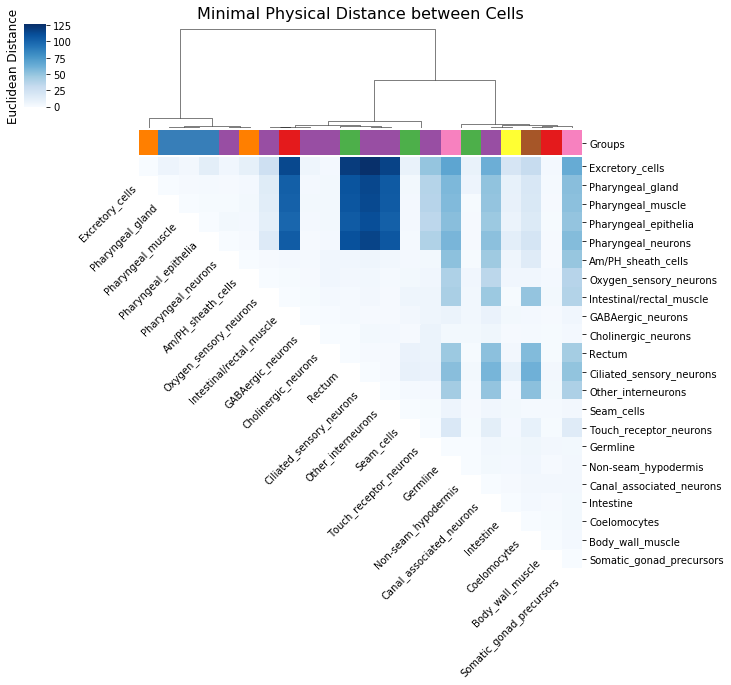

In [18]:
hier = c2c.utils.clustermap_cci(distance_matrix,
                                method='complete',
                                title='Minimal Physical Distance between Cells',
                                cbar_title='Euclidean Distance',
                                filename='../Figures/Celegans-3D-Atlas-Clustering.svg',
                                group_col='Groups',
                                sample_col='#SampleID',
                                colors=colors,
                                metadata=meta,
                                excluded_cells=excluded_cells,
                                **{'cmap' : 'Blues',
                                   #'vmin' : 0.0,
                                   #'vmax' : 50
                                  }
                               )

In [19]:
cell_order = []
for cell in meta['#SampleID'].values:
    if cell in distance_matrix.index:
        cell_order.append(cell)

Interaction space detected as a distance matrix


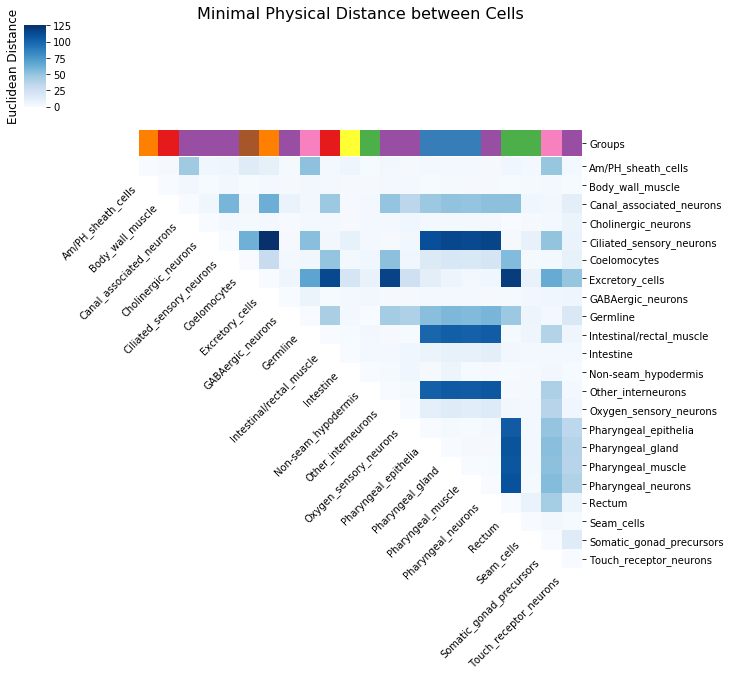

In [20]:
clus = c2c.utils.clustermap_cci(distance_matrix.loc[sorted(cell_order), sorted(cell_order)],
                                title='Minimal Physical Distance between Cells',
                                cbar_title='Euclidean Distance',
                                filename='../Figures/Celegans-3D-Atlas-Heatmap.svg',
                                group_col='Groups',
                                sample_col='#SampleID',
                                colors=colors,
                                metadata=meta,
                                excluded_cells=excluded_cells,
                                **{'cmap' : 'Blues',
                                   'col_cluster' : False,
                                   'row_cluster' : False
                                   #'vmin' : 0.0,
                                   #'vmax' : 50
                                  }
                               )

In [21]:
from sklearn.mixture import GaussianMixture

In [22]:
distance_distrib = scipy.spatial.distance.squareform(distance_matrix.values)

In [23]:
gaussian_dists = GaussianMixture(n_components=3)
gaussian_dists.fit(distance_distrib.reshape(-1, 1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [24]:
gaussian_dists.means_

array([[  2.89665053],
       [110.04239878],
       [ 32.89340957]])

In [25]:
labels = gaussian_dists.predict(distance_distrib.reshape(-1, 1))

In [26]:
def map_color(label):
    if label == 0:
        return 'red'
    if label == 1:
        return 'blue'
    if label == 2:
        return 'orange'
    else:
        return 'purple'

In [27]:
dist_df = pd.DataFrame()
dist_df['Distances'] = distance_distrib.flatten()
dist_df['Labe1'] = labels
dist_df['Color'] = list(map(map_color, labels))

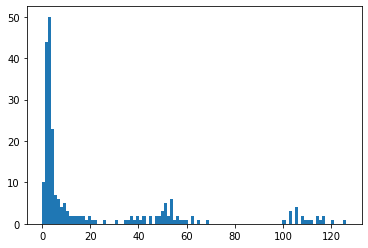

In [28]:
dist_bins = plt.hist(distance_distrib, bins=100)

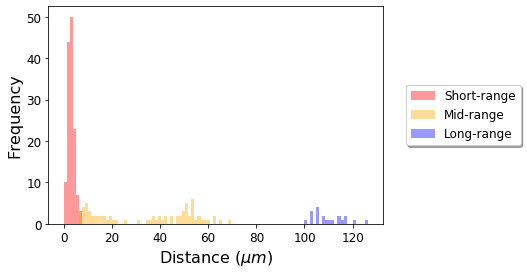

In [29]:
for c, df in dist_df.groupby('Color', sort=False):
    bins = np.ceil(len(df)/len(dist_df)*100)
    sns.distplot(df['Distances'], color=c, kde=False, bins=dist_bins[1], label=c) #int(bins))
    
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Distance ($\mu m$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

lgd = plt.legend(labels=['Short-range', 'Mid-range', 'Long-range'], loc='center left',
                 bbox_to_anchor=(1.05, 0.5),
                 fancybox=True, shadow=True, fontsize=12)
plt.savefig('../Figures/Celegans-3D-Atlas-Distance-Distribution.svg',
            dpi=300,
            bbox_inches='tight')

In [30]:
dist_df.sort_values(['Distances'], ascending=True).to_csv('../Data/Digital-3D-Map/Distance-Distribution.csv', index=False)

In [31]:
scipy.spatial.distance.squareform(distance_matrix.values).shape

(231,)

# PCoA

Interaction space detected as a distance matrix


/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -13461.84523911331 and the largest is 27598.37853727179.
  RuntimeWarning


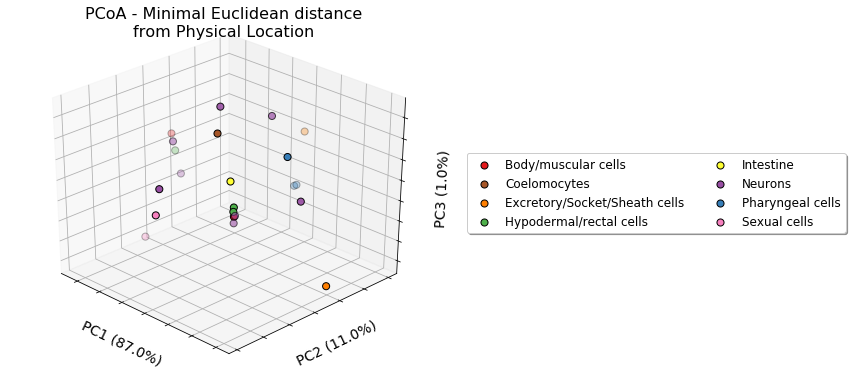

In [32]:
pcoa = c2c.utils.pcoa_biplot(distance_matrix,
                             meta.loc[meta['#SampleID'].isin(distance_matrix.index)],
                             sample_col='#SampleID',
                             group_col='Groups',
                             colors=lut,
                             title='PCoA - Minimal Euclidean distance\nfrom Physical Location',
                             filename='../Figures/Celegans-3D-Atlas-PCoA.svg'
                             )

In [33]:
#meta.to_csv("../outputs/metadata.tsv", sep="\t", index=False)
#pcoa['ordination'].write('../outputs/Physical_Location_Ord.txt')